Empezamos como en el otro ejercicio, importando todo lo que necesitamos.

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import cv2

In [0]:
from keras.models import Sequential, Model
from keras.layers import GRU, Dropout, Dense, Embedding, TimeDistributed, Merge, RepeatVector, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint
import cv2, os, numpy as np
from keras.preprocessing import text, sequence

Como CNN vamos a usar InceptionV3.

In [2]:
from keras.applications.inception_v3 import InceptionV3
img_model = InceptionV3(include_top=True)

96116736/96112376 [==============================] - 6s 0us/step


Descargamos nuestro dataset tanto las descripciones como las fotos.

In [3]:
!wget http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_text.zip
!unzip -o Flickr8k_text.zip

--2018-08-14 18:44:14--  http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_text.zip
Resolving nlp.cs.illinois.edu (nlp.cs.illinois.edu)... 192.17.58.132
Connecting to nlp.cs.illinois.edu (nlp.cs.illinois.edu)|192.17.58.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2340801 (2.2M) [application/zip]
Saving to: ‘Flickr8k_text.zip’

Flickr8k_text.zip   100%[===================>]   2.23M  1.27MB/s    in 1.8s    

2018-08-14 18:44:17 (1.27 MB/s) - ‘Flickr8k_text.zip’ saved [2340801/2340801]

Archive:  Flickr8k_text.zip
  inflating: CrowdFlowerAnnotations.txt  
  inflating: ExpertAnnotations.txt   
  inflating: Flickr8k.lemma.token.txt  
   creating: __MACOSX/
  inflating: __MACOSX/._Flickr8k.lemma.token.txt  
  inflating: Flickr8k.token.txt      
  inflating: Flickr_8k.devImages.txt  
  inflating: Flickr_8k.testImages.txt  
  inflating: Flickr_8k.trainImages.txt  
  inflating: readme.txt              


In [6]:
!wget http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip
!unzip -q Flickr8k_Dataset.zip

--2018-08-14 18:46:10--  http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip
Resolving nlp.cs.illinois.edu (nlp.cs.illinois.edu)... 192.17.58.132
Connecting to nlp.cs.illinois.edu (nlp.cs.illinois.edu)|192.17.58.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115419746 (1.0G) [application/zip]
Saving to: ‘Flickr8k_Dataset.zip’

Flickr8k_Dataset.zi 100%[===================>]   1.04G  25.8MB/s    in 44s     

2018-08-14 18:46:54 (24.1 MB/s) - ‘Flickr8k_Dataset.zip’ saved [1115419746/1115419746]



In [8]:
!ls -l

total 1101892
-rw-r--r-- 1 root root    2918552 Oct 14  2013 CrowdFlowerAnnotations.txt
drwxr-xr-x 3 root root       4096 Aug 13 21:16 datalab
-rw-r--r-- 1 root root     346674 Oct 14  2013 ExpertAnnotations.txt
drwxr-xr-x 2 root root     417792 Oct  3  2012 Flicker8k_Dataset
-rw-r--r-- 1 root root 1115419746 Oct 24  2013 Flickr8k_Dataset.zip
-rw-r--r-- 1 root root      25801 Oct 10  2013 Flickr_8k.devImages.txt
-rw-r--r-- 1 root root    3244761 Feb 16  2012 Flickr8k.lemma.token.txt
-rw-r--r-- 1 root root      25775 Oct 10  2013 Flickr_8k.testImages.txt
-rw-r--r-- 1 root root    2340801 Oct 28  2013 Flickr8k_text.zip
-rw-r--r-- 1 root root    3395237 Oct 14  2013 Flickr8k.token.txt
-rw-r--r-- 1 root root     154678 Oct 10  2013 Flickr_8k.trainImages.txt
drwxrwxr-x 3 root root       4096 Aug 14 18:47 __MACOSX
-rw-r--r-- 1 root root       1821 Oct 14  2013 readme.txt


Vamos a tratar las descripciones: contamos las palabras, las pasamos a números y creamos también las secuencias.

In [0]:
class FlickrData:
    def __init__(self, path='Flickr8k.token.txt', n_vocab=100, max_seq_len=16):
        self.img_to_caps = dict()

        print('Opening file, creating img_to_caps...')
        with open(path, 'r') as f:
            for line in f:
                tokens = line.split(' ')
                img_fname, num = tokens[0].split('#')
                caption = ' '.join(tokens[1:]).strip()
                if img_fname not in self.img_to_caps: self.img_to_caps[img_fname] = []
                self.img_to_caps[img_fname].append(caption)
        self.img_fnames = list(self.img_to_caps.keys())

        print('Getting word counts, creating word_to_int and int_to_word...')
        texts = []
        self.tk = text.Tokenizer(nb_words=n_vocab)
        for img_fname in self.img_fnames:
            texts += self.img_to_caps[img_fname]

        self.tk.fit_on_texts(texts)
        self.sorted_word_counts = sorted(self.tk.word_counts.items(), key=lambda x: x[1])
        self.sorted_word_counts = self.sorted_word_counts[::-1][:n_vocab]
        self.word_to_int = {t[0]: i for i,t in enumerate(self.sorted_word_counts)}
        self.int_to_word = {i: t[0] for i,t in enumerate(self.sorted_word_counts)}
        
        print('Creating sequences...')
        img_to_seqs = {}
        
        for img_fname, captions in self.img_to_caps.items():
            seqs = []
            for caption in captions:
                seqs.append([self.word_to_int[w] for w in caption.split() if w in self.word_to_int])
            img_to_seqs[img_fname] = seqs
            
        print('Creating partial padded sequences and corresponding next chars...')
        self.img_to_padded_seqs, self.img_to_next_chars = {}, {}
        
        for img_fname, seqs in img_to_seqs.items():
            partial_seqs = []
            next_words = []
            for seq in seqs:
                for i in range(1,len(seq)):
                    partial_seqs.append(seq[:i])
                    next_words.append(seq[i])
            padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_seq_len)

            next_words_1hot = np.zeros([len(next_words), n_vocab], dtype=np.bool)
            for i,next_word in enumerate(next_words):
                next_words_1hot[i,next_word] = 1
            self.img_to_padded_seqs[img_fname] = padded_partial_seqs
            self.img_to_next_chars[img_fname] = next_words_1hot

                
    def get_img(self, img_fname, img_size=(299,299), path='Flicker8k_Dataset'):
        img_path = os.path.join(path, img_fname)
        return cv2.resize(cv2.imread(img_path), img_size).astype(np.float32)

In [12]:
print('Loading Flickr data...')

#from utils import FlickrData
n_vocab = 100
max_seq_len = 16
data = FlickrData(n_vocab=n_vocab, max_seq_len=max_seq_len)
print('Done.')

Loading Flickr data...
Opening file, creating img_to_caps...
Getting word counts, creating word_to_int and int_to_word...


/usr/local/lib/python3.6/dist-packages/keras/preprocessing/text.py:172: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Creating sequences...
Creating partial padded sequences and corresponding next chars...
Done.


Empezamos con nuestro modelo. Lo primero que hacemos es aplicar InceptionV3 a un vector para cargar el modelo de imágenes.

In [13]:
print('Loading image model (InceptionV3)... ', end='')
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
pretrained_img_model = InceptionV3(include_top=True)
img_size = (299,299)
print('Done.')

Loading image model (InceptionV3)... Done.


Y ahora construimos el modelo con las descripciones.

In [14]:
print('Building language model...')

language_model = Sequential()
language_model.add(Embedding(n_vocab, 256, input_length=max_seq_len))
language_model.add(GRU(return_sequences=True, units=128))
language_model.add(TimeDistributed(Dense(128)))

Building language model...


Volvemos a procesar el model de imágenes

In [15]:
print('Building full model...')

# Repeat the image vector
img_input = pretrained_img_model.inputs[0]
img_output = pretrained_img_model.outputs[0]
img_output = RepeatVector(16)(img_output)
image_model = Model(inputs=img_input, outputs=img_output)

Building full model...


Juntamos los dos modelos anteriores.

In [16]:
from keras.layers.merge import Concatenate
# Concatenate the two models

model = Sequential()
model.add(Merge([image_model, language_model], mode='concat', concat_axis=-1))

# Add another GRU, computes softmax over words
model.add(GRU(256, return_sequences=False))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
print('Done.')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """


Done.


In [0]:
model_checkpoint = ModelCheckpoint('weights.{epoch:02d}-{loss:.2f}.hdf5', monitor='loss', verbose=0,
                                  save_best_only=True, mode='min')
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=False)
callbacks_list = [model_checkpoint, tensorboard]

In [0]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas) 

In [0]:
def generate_caption(model, img, temperature):
    curr_seq = np.zeros([1,max_seq_len])
    for _ in range(max_seq_len):
        prediction = model.predict([img,curr_seq])
        sample_idx = int(sample(prediction[0],temperature))
        next_word = data.sorted_word_counts[sample_idx][0]
        curr_seq[0,:max_seq_len-1] = curr_seq[0,1:]
        curr_seq[0,max_seq_len-1] = sample_idx
        print(next_word, end=' ')
    print()

def show_image(img):
    b,g,r = cv2.split(img)
    curr_img = cv2.merge([r,g,b])
    curr_img = curr_img - np.min(curr_img)
    curr_img = curr_img / np.max(curr_img)
    plt.imshow(curr_img)
    plt.show()

Aquí lo vemos en funcionamiento escogiendo unas fotografías al azar y generando una descripción (no muy acertada...)

Fitting model...
---- Current epoch 0 ----



Grabbing images...Done.
Sample image and generated caption:


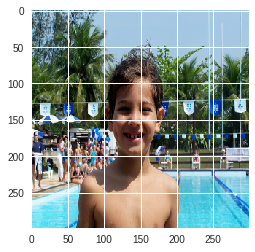

play little looking her woman dog are hat the toy air girls air toy field down 
---- Current epoch 1 ----



Grabbing images...Done.
Sample image and generated caption:


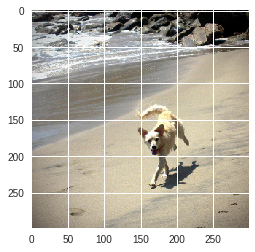

off one background for standing young pool dirt stands up rock woman a runs on over 
---- Current epoch 2 ----



Grabbing images...Done.
Sample image and generated caption:


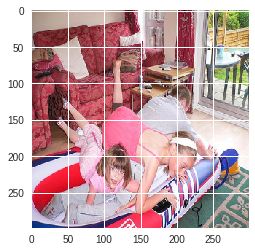

by children the brown toy holding jumping player street holding wearing through with outside group group 
---- Current epoch 3 ----



Grabbing images...Done.
Sample image and generated caption:


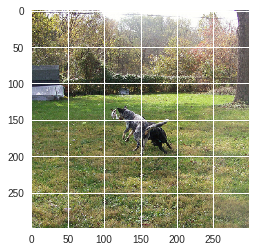

dog little red beach the running blue young other air another runs girls mouth dogs ball 
---- Current epoch 4 ----



Grabbing images...Done.
Sample image and generated caption:


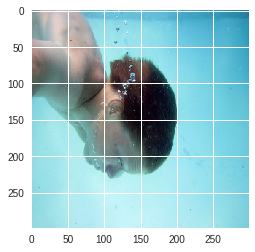

mouth wearing front hat next grass playing outside small down a woman out behind around sitting 
---- Current epoch 5 ----



Grabbing images...Done.
Sample image and generated caption:


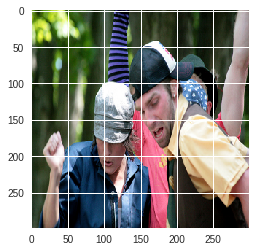

off in bike stands large street running street looking their brown on toy toy children red 
---- Current epoch 6 ----



Grabbing images...Done.
Sample image and generated caption:


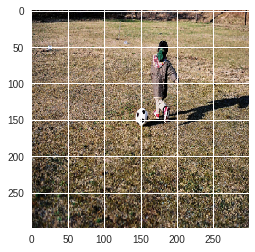

blue behind green two child people green red people snow little beach jacket from toy shirt 
---- Current epoch 7 ----



Grabbing images...Done.
Sample image and generated caption:


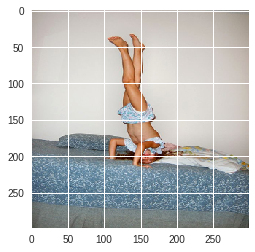

with one dog dirt orange hat player red up jacket orange another one yellow women stands 
---- Current epoch 8 ----



Grabbing images...Done.
Sample image and generated caption:


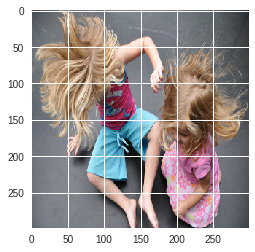

one green women with field standing sitting jumping off men orange jumping running yellow a into 
---- Current epoch 9 ----



Grabbing images...Done.
Sample image and generated caption:


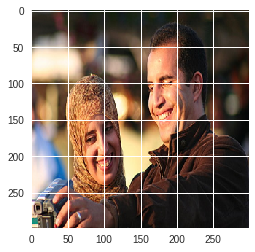

camera in green for large white walking by white snow outside dirt ball person ball ball 


In [23]:
print('Fitting model...')

nb_epochs = 10
batch_size = 8
num_img_per_epoch = 1
temperature = 1.0
do_fit = False


for curr_epoch in range(nb_epochs):
    print('---- Current epoch', curr_epoch, '----\n\n\n')
    images = np.zeros([0,img_size[0],img_size[1],3])
    captions = np.zeros([0, max_seq_len])
    next_words = np.zeros([0,n_vocab])
    print('Grabbing images...', end='')
    for i in range(num_img_per_epoch):
        img_fname = random.choice(data.img_fnames)
        orig_img = data.get_img(img_fname)
        img = preprocess_input(orig_img)
        img = np.expand_dims(img, axis=0)
        padded_seqs, seq_end = data.img_to_padded_seqs[img_fname], data.img_to_next_chars[img_fname]
        
        n_seqs = padded_seqs.shape[0]
        img_matrix = np.repeat(img,repeats=n_seqs,axis=0)
        images = np.concatenate([images, img_matrix], axis=0)
        captions = np.concatenate([captions, padded_seqs])
        next_words = np.concatenate([next_words, seq_end])
    print('Done.')
    
    print('Sample image and generated caption:')
    show_image(orig_img)
    
    generate_caption(model, img, temperature)
    
    if do_fit:
        print('Fitting epoch...')
        model.fit([images, captions], next_words, batch_size=batch_size, nb_epoch=1, callbacks=callbacks_list, shuffle=False)
        print('Caption after fitting:\n')
        generate_caption(model, img, temperature)